# Final Project 607

## Introduction

Today I will attempt to use a neural network model to detect reading levels based on a provided text.

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from transformers import BertTokenizer
import tensorflow as tf


2024-05-06 22:21:25.243759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

This dataset was generated from ChatGPT 3.5, I asked 20 questions and ask for their response in every grade level.

In [2]:
csv_file =  "https://raw.githubusercontent.com/jamilton08/reading_level_language/main/grade_level_dataset%20-%20Sheet1.csv"

df = pd.read_csv(csv_file)

In [3]:
df.head()

,question,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,How do you think we can make our school/commun...,By picking up trash and being kind to everyone.,We can clean up the playground and help new st...,We can organize clean-up days and start clubs ...,"""We can pick up trash, plant flowers, and be k...","We can organize clean-up days, start recycling...",We can organize fundraisers for local charitie...,"""We can organize community service projects, a...","""We can initiate community service projects, e...","""We can organize more student-led initiatives ...","""We can organize more student-led initiatives ...","""We can implement more student-driven initiati...","""We can promote inclusivity and diversity thro..."
1,What are some important problems facing our wo...,Helping animals find homes and sharing toys wi...,Helping animals find homes and recycling to ke...,"Helping animals find homes, reducing pollution...","""Pollution, animals losing their homes, and pe...","Issues like pollution, poverty, and animal ext...","Climate change, poverty, and inequality are pr...","""Issues like climate change, poverty, and soci...","""Climate change, social inequality, and global...","""Climate change, income inequality, and system...","""Climate change, social inequality, and global...","""Climate change, social injustice, and global ...","""Climate change, social injustice, and global ..."
2,Can you describe a time when you had to overco...,I learned to tie my shoes all by myself!,I learned to ride my bike without training whe...,I learned to ride a bike without training whee...,"""I was scared to give a speech in class, but I...","Last year, I was nervous about giving a presen...","Last year, I struggled with math, but with per...","""Last year, I struggled with time management a...","""Last year, I faced academic setbacks due to h...","""Last year, I struggled with balancing academi...","""Last year, I struggled with time management a...","""Last year, I faced academic pressure and stru...","""Last year, I faced academic pressure and stru..."
3,"What does success mean to you, and how do you ...",Success is getting a gold star! I'll try my be...,Success is doing well on my spelling test and ...,"Success is doing well in school, being a good ...","""Success is when I do my best and feel proud o...","Success means doing well in school, being kind...","Success is achieving personal goals, making a ...","""Success, to me, is achieving personal goals, ...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill..."
4,How do you think technology has changed the wa...,I can talk to my grandma on the computer!,We can video chat with family far away and sen...,"We can talk to friends and family far away, do...","""Technology lets us talk to friends far away, ...",Technology lets us talk to friends and family ...,"Technology has revolutionized communication, a...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ..."


In [4]:
df = pd.melt(df,id_vars = ["question"], var_name = "grade", value_name = "response")

In [5]:
##clean data removing punctuations and etc
df["grade"] = df["grade"].str.replace("grade_", "")
df["response"] = df["response"].str.replace("\.|!|\"|-|,|'", "")
df["grade"] = df["grade"].astype(int)
df["id"] = df.reset_index().index
df.tail()

,question,grade,response,id
235,How do you think we can encourage more creativ...,12,"""Schools and workplaces can promote creativity...",235
236,What role do you believe ethics and morality s...,12,"""Ethics and morality provide guiding principle...",236
237,Can you describe a time when you had to make a...,12,"""When faced with a difficult decision, such as...",237
238,How do you think social media has influenced o...,12,"""Social media has influenced our self-image an...",238
239,"What are your aspirations for the future, and ...",12,"""I aspire to pursue a career in technology and...",239


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  240 non-null    object
 1   grade     240 non-null    int64 
 2   response  240 non-null    object
 3   id        240 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 7.6+ KB


In [7]:
df.head()

,question,grade,response,id
0,How do you think we can make our school/commun...,1,By picking up trash and being kind to everyone.,0
1,What are some important problems facing our wo...,1,Helping animals find homes and sharing toys wi...,1
2,Can you describe a time when you had to overco...,1,I learned to tie my shoes all by myself!,2
3,"What does success mean to you, and how do you ...",1,Success is getting a gold star! I'll try my be...,3
4,How do you think technology has changed the wa...,1,I can talk to my grandma on the computer!,4


## Tokenizing

In [8]:
# bert tokenizes words by putting words to their base models which serves as a consistent
#way for analysis being that every word is brung to their most basic form
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
# sample of response
df["response"].iloc[0]


'By picking up trash and being kind to everyone.'

In [10]:
# many deep learning architectures processes language at the token level and hugging face has 
# bert which does just that for us
token = tokenizer.encode_plus(
df['response'].iloc[0],
max_length = 512,
truncation = True,
padding = 'max_length',
add_special_tokens=True,
return_tensors="tf")

In [11]:
token

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[  101,  1650,  8184,  1146, 13151,  1105,  1217,  1912,  1106,
         2490,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

## Initializing Training Data

In [12]:
# create ids and masks to populate them with what we recieve from tokenizer
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [13]:
X_input_ids.shape

(240, 256)

In [14]:
# build a function that will loop trough each row of the my dataframe is text and encode
#them and tokenize them then populate our id and mask dataframe
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df["response"])):
        tokenized_text = tokenizer.encode_plus(
        text,
        max_length = 256,
        truncation = True,
        padding = 'max_length',
        add_special_tokens = True,
        return_tensors = 'tf')
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [15]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [16]:
X_input_ids

array([[  101.,  1650.,  8184., ...,     0.,     0.,     0.],
       [  101., 12056.,  1158., ...,     0.,     0.,     0.],
       [  101.,   146.,  3560., ...,     0.,     0.,     0.],
       ...,
       [  101.,   107.,  1332., ...,     0.,     0.,     0.],
       [  101.,   107.,  3563., ...,     0.,     0.,     0.],
       [  101.,   107.,   146., ...,     0.,     0.,     0.]])

In [17]:
## labels based on how many outputs we have 
labels = np.zeros((len(df), 12))

In [18]:
## one hot encoding where our classification index indicator will become 1 in an n by m 
# matrix
labels[np.arange(len(df)), df["grade"].values - 1] = 1

In [19]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [20]:
## tensorflow does a good job in create a mapped dataset of our inputs to the expected outputs
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))

In [21]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(12,), dtype=tf.float64, name=None))>

In [22]:
## will be used to rearrange the output of the result when we map
def  GradeDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids':input_ids,
        'attention_masks' : attn_masks
    }, labels

In [23]:
dataset = dataset.map(GradeDatasetMapFunction)

In [24]:
#shuffle 
dataset = dataset.shuffle(10000).batch(16, drop_remainder = True)

In [25]:
## get train size based on what percent we want to be training which is 80% of our data
p = 0.8
train_size = int((len(df)//16)*p)

In [26]:
train_size

12

In [27]:
df.shape

(240, 4)

In [28]:
## common in all machine learning to seperate data,, one section to train and the other to test
train_data = dataset.take(train_size)
testing_data = dataset.skip(train_size)

## Structure  Network

In [30]:
from transformers import BertConfig, TFBertModel

config = BertConfig.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased', config=config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [31]:
#input values
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype = 'int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name='attention_masks', dtype = 'int32')

# hidden layer, my understanding is that were not dealing with probability here cause it's
# not just a binary classification which means we are working with values greater then 1
# hence it serves us better for this multiclassification problem, sigmoid is continously,
# divides one by one it self or greater making it one or less which if it goes over a threshold
# based on probability then we classifh
bert_embds = bert_model.bert(input_ids, attention_mask = attention_masks)[1]
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermediate_layer')(bert_embds)

#output layer, we use softmax since were dealing with a multiclass which is a vector of 
#probabilities and based on where we fall for each output is probability we can identify 
# our class with softmax
output_layer = tf.keras.layers.Dense(12, activation = 'softmax', name="output_layer")(intermediate_layer)

model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 256)]                0         []                            
 r)                                                                                               
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_masks[0][0]']     
                             hidden_state=(None, 256, 7                                       

In [32]:
# optim will reduce our loss, which backproporgation calculate the gradient of our loss to 
# update the weights and when the weights are optimized we will get our best accuracy.
#  Categorical cross entropy is used in multiclassification and our accuracy is based on 
# how often the predictions of this model matches the one hot encode from earlier.
optim = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer = optim, loss = loss_func, metrics=[acc])

## Build Network

In [33]:
model.compile(optimizer = optim, loss = loss_func, metrics=[acc])

## Train Network

I I began to notice during cross validation that accuracy would decrease in some instance and feared that my model was gearing towards overfitting leading me to stop at 50 epochs.

In [39]:
# training model, I did 50 epochs and the accuracy was not changing much at the end.
# epochs use cross validation and uses a blocks of the dataset to train the model, reads
# the loss, calculate the gradients and repeats every epoch and then recalculates blocks of data
# and repeats trying to find the diffirences and adjust accordingly.
hist = model.fit(
    train_data,
    validation_data = testing_data,
    epochs = 5
)

Epoch 1/5
12/12 [==============================] - 152s 13s/step - loss: 0.6716 - accuracy: 0.7240 - val_loss: 0.6259 - val_accuracy: 0.7500
Epoch 2/5
12/12 [==============================] - 152s 13s/step - loss: 0.6859 - accuracy: 0.7448 - val_loss: 0.6591 - val_accuracy: 0.7083
Epoch 3/5
12/12 [==============================] - 151s 13s/step - loss: 0.7096 - accuracy: 0.7031 - val_loss: 0.6818 - val_accuracy: 0.7708
Epoch 4/5
12/12 [==============================] - 154s 13s/step - loss: 0.6978 - accuracy: 0.7344 - val_loss: 0.6123 - val_accuracy: 0.7083
Epoch 5/5
12/12 [==============================] - 154s 13s/step - loss: 0.6956 - accuracy: 0.7396 - val_loss: 0.6850 - val_accuracy: 0.7500


In [62]:
model.save("reading_level_model")

NameError: name 'model' is not defined

## Test Network

I used the same dataset I trained the netowrk with as generating another dataset is very time consuming. 

In [35]:

load_model = tf.keras.models.load_model("reading_level_model")

In [36]:
## Tokenize regular input now 
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length = 256,
        truncation = True,
        padding = 'max_length',
        add_special_tokens=True,
        return_tensors="tf"
    )
    return {
        'input_ids' : tf.cast(token.input_ids, tf.float64),
        'attention_masks' : tf.cast(token.attention_mask, tf.float64)
    }

In [37]:
text = "Skunks have a special way to protect themselves when they feel scared or threatened. They can spray a really stinky liquid from their bodies. This liquid smells really bad, like rotten eggs or a stinky garbage can! Skunks spray this smelly stuff to scare away animals that might want to hurt them. So, when you smell a skunk, it's because it's trying to stay safe by making itself smell really awful to other animals."

In [38]:
t_text = prepare_data(text, tokenizer)

In [39]:
t_text

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=float64, numpy=
 array([[  101.,   156.,  4786., 18683.,  1138.,   170.,  1957.,  1236.,
          1106.,  3244.,  2310.,  1165.,  1152.,  1631.,  5528.,  1137.,
          4963.,   119.,  1220.,  1169., 13477.,   170.,  1541.,   188.,
          6105.,  3781.,  6161.,  1121.,  1147.,  3470.,   119.,  1188.,
          6161., 16533.,  1541.,  2213.,   117.,  1176., 23076.,  6471.,
          1137.,   170.,   188.,  6105.,  3781., 14946.,  1169.,   106.,
           156.,  4786., 18683., 13477.,  1142.,  4773.,  1183.,  4333.,
          1106., 13671.,  1283.,  3551.,  1115.,  1547.,  1328.,  1106.,
          2644.,  1172.,   119.,  1573.,   117.,  1165.,  1128.,  4773.,
           170.,   188.,  4786.,  6773.,   117.,  1122.,   112.,   188.,
          1272.,  1122.,   112.,   188.,  1774.,  1106.,  2215.,  2914.,
          1118.,  1543.,  2111.,  4773.,  1541.,  9684.,  1106.,  1168.,
          3551.,   119.,   102.,     0.,     0.,     0.,    

In [40]:
softmaxvect = load_model(t_text)

In [41]:
softmaxvect

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[2.2868030e-03, 2.2854470e-02, 1.9612368e-02, 7.9852139e-04,
        9.1733634e-01, 5.0742612e-03, 6.5306746e-03, 9.6230675e-03,
        2.4455162e-03, 6.7150472e-03, 2.3490358e-03, 4.3738089e-03]],
      dtype=float32)>

In [42]:
m = np.argmax(softmaxvect[0])
m

4

In [43]:
## load test 
csv_file =  "https://raw.githubusercontent.com/jamilton08/reading_level_language/main/grade_level_dataset%20-%20Sheet1.csv"

df = pd.read_csv(csv_file)
df.head()


,question,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,How do you think we can make our school/commun...,By picking up trash and being kind to everyone.,We can clean up the playground and help new st...,We can organize clean-up days and start clubs ...,"""We can pick up trash, plant flowers, and be k...","We can organize clean-up days, start recycling...",We can organize fundraisers for local charitie...,"""We can organize community service projects, a...","""We can initiate community service projects, e...","""We can organize more student-led initiatives ...","""We can organize more student-led initiatives ...","""We can implement more student-driven initiati...","""We can promote inclusivity and diversity thro..."
1,What are some important problems facing our wo...,Helping animals find homes and sharing toys wi...,Helping animals find homes and recycling to ke...,"Helping animals find homes, reducing pollution...","""Pollution, animals losing their homes, and pe...","Issues like pollution, poverty, and animal ext...","Climate change, poverty, and inequality are pr...","""Issues like climate change, poverty, and soci...","""Climate change, social inequality, and global...","""Climate change, income inequality, and system...","""Climate change, social inequality, and global...","""Climate change, social injustice, and global ...","""Climate change, social injustice, and global ..."
2,Can you describe a time when you had to overco...,I learned to tie my shoes all by myself!,I learned to ride my bike without training whe...,I learned to ride a bike without training whee...,"""I was scared to give a speech in class, but I...","Last year, I was nervous about giving a presen...","Last year, I struggled with math, but with per...","""Last year, I struggled with time management a...","""Last year, I faced academic setbacks due to h...","""Last year, I struggled with balancing academi...","""Last year, I struggled with time management a...","""Last year, I faced academic pressure and stru...","""Last year, I faced academic pressure and stru..."
3,"What does success mean to you, and how do you ...",Success is getting a gold star! I'll try my be...,Success is doing well on my spelling test and ...,"Success is doing well in school, being a good ...","""Success is when I do my best and feel proud o...","Success means doing well in school, being kind...","Success is achieving personal goals, making a ...","""Success, to me, is achieving personal goals, ...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill...","""Success, to me, is achieving personal fulfill..."
4,How do you think technology has changed the wa...,I can talk to my grandma on the computer!,We can video chat with family far away and sen...,"We can talk to friends and family far away, do...","""Technology lets us talk to friends far away, ...",Technology lets us talk to friends and family ...,"Technology has revolutionized communication, a...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ...","""Technology has revolutionized communication, ..."


In [44]:
##clean data removing punctuations and etc
df = pd.melt(df,id_vars = ["question"], var_name = "grade", value_name = "response")
df["grade"] = df["grade"].str.replace("grade_", "")
df["response"] = df["response"].str.replace("\.|!|\"|-|,|'", "")
df["grade"] = df["grade"].astype(int)
df["id"] = df.reset_index().index
df.tail()

,question,grade,response,id
235,How do you think we can encourage more creativ...,12,"""Schools and workplaces can promote creativity...",235
236,What role do you believe ethics and morality s...,12,"""Ethics and morality provide guiding principle...",236
237,Can you describe a time when you had to make a...,12,"""When faced with a difficult decision, such as...",237
238,How do you think social media has influenced o...,12,"""Social media has influenced our self-image an...",238
239,"What are your aspirations for the future, and ...",12,"""I aspire to pursue a career in technology and...",239


In [45]:
empt_list = list()

for index, row in df.iterrows():
    print(row['response'])
    tokened_text = prepare_data(row['response'], tokenizer)
    pred = load_model.predict(tokened_text)
    grade = np.argmax(pred[0])
    empt_list.append(grade)
    print(grade)
    


By picking up trash and being kind to everyone.
1/1 [==============================] - 8s 8s/step
0
Helping animals find homes and sharing toys with friends.
1/1 [==============================] - 0s 269ms/step
0
I learned to tie my shoes all by myself!
1/1 [==============================] - 0s 274ms/step
0
Success is getting a gold star! I'll try my best in school.
1/1 [==============================] - 0s 275ms/step
0
I can talk to my grandma on the computer!
1/1 [==============================] - 0s 268ms/step
0
We need to water plants so they can grow big and strong!
1/1 [==============================] - 0s 274ms/step
0
Everyone should get a turn on the slide at recess!
1/1 [==============================] - 0s 273ms/step
0
I like having friends who like different colors and toys.
1/1 [==============================] - 0s 270ms/step
0
I like drawing pictures of animals! It makes me happy.
1/1 [==============================] - 0s 272ms/step
0
Happiness is playing with my friends a

In [46]:
df.shape[0]

240

In [47]:
print(empt_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 11, 7, 7, 7, 7, 11, 11, 11, 7, 11, 7, 11, 6, 8, 8, 8, 11, 11, 11, 9, 11, 7, 11, 11, 11, 11, 11, 11, 11, 11, 7, 11, 11, 11, 11, 11, 9, 9, 11, 11, 11, 11, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [48]:
df["predicted"] = empt_list
df["predicted"] = df["predicted"] + 1
df["correct"] = np.where(df['grade'] == df["predicted"], 1, 0)

In [49]:
df

,question,grade,response,id,predicted,correct
0,How do you think we can make our school/commun...,1,By picking up trash and being kind to everyone.,0,1,1
1,What are some important problems facing our wo...,1,Helping animals find homes and sharing toys wi...,1,1,1
2,Can you describe a time when you had to overco...,1,I learned to tie my shoes all by myself!,2,1,1
3,"What does success mean to you, and how do you ...",1,Success is getting a gold star! I'll try my be...,3,1,1
4,How do you think technology has changed the wa...,1,I can talk to my grandma on the computer!,4,1,1
...,...,...,...,...,...,...
235,How do you think we can encourage more creativ...,12,"""Schools and workplaces can promote creativity...",235,12,1
236,What role do you believe ethics and morality s...,12,"""Ethics and morality provide guiding principle...",236,12,1
237,Can you describe a time when you had to make a...,12,"""When faced with a difficult decision, such as...",237,12,1
238,How do you think social media has influenced o...,12,"""Social media has influenced our self-image an...",238,12,1


## Accuracy

In [50]:
corrects = df["correct"].value_counts()

accuracy = corrects[1] / df.shape[0]

print("the full dataset predicted's accuracy is : {}".format(accuracy))

the full dataset predicted's accuracy is : 0.75


Realistically the dataset is too small to train the network for real life use, I would have to gather a much bigger
dataset as 75 percent accuracy seems to be a good value if in real life use it predicted with such probability. I will know see the distribution of how far off were the incorrect grades 

In [51]:
wrong_values = df[df["correct"] == 0]

## Incorrect Results Analysis


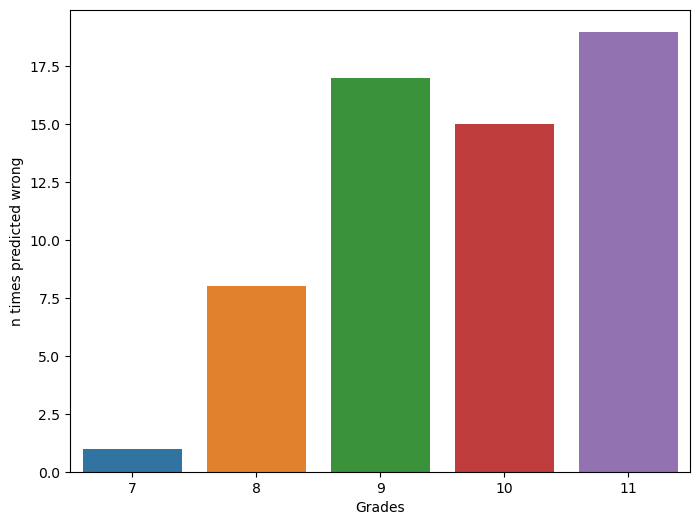

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='grade', data=wrong_values)
plt.xlabel('Grades')
plt.ylabel('n times predicted wrong')
plt.show()

High school grades seem to get confused alot, but now we will check by how much were they wrong in general

In [53]:
wrong_values["diff"] = wrong_values["predicted"]- wrong_values["grade"] 

wrong_values.head()

/var/folders/wq/f81608x139521h3608zprcr40000gn/T/ipykernel_4575/2550657404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_values["diff"] = wrong_values["predicted"]- wrong_values["grade"]


,question,grade,response,id,predicted,correct,diff
127,How do you think diversity and inclusion contr...,7,"""Diversity fosters innovation, creativity, and...",127,8,0,1
140,How do you think we can make our school/commun...,8,"""We can initiate community service projects, e...",140,7,0,-1
147,How do you think diversity and inclusion contr...,8,"""Diversity and inclusion enrich communities by...",147,12,0,4
152,What do you believe are the most important qua...,8,"""Good leaders demonstrate integrity, empathy, ...",152,12,0,4
153,How do you think globalization has impacted ou...,8,"""Globalization has facilitated cultural exchan...",153,12,0,4


## Grade Level Distance Distribution

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


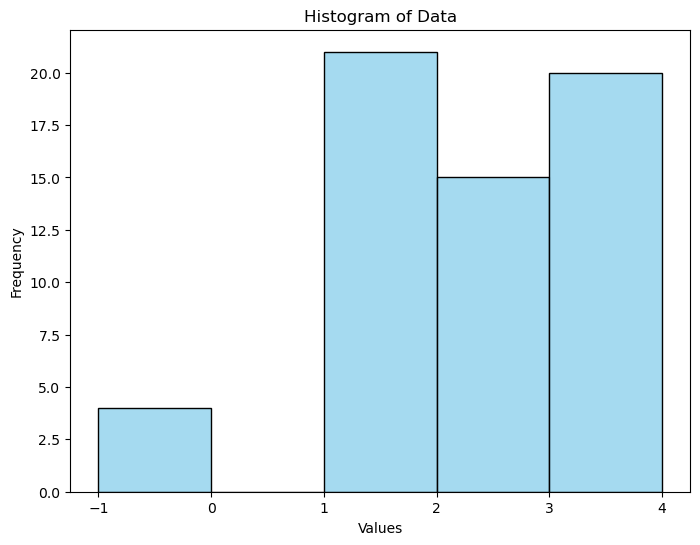

In [54]:
plt.figure(figsize=(8, 6))
sns.histplot(wrong_values["diff"], bins=5, kde=False, color='skyblue')
plt.title('Histogram of Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

## High School Levels Justification
This means grades were mainly predicted to be above reading level by one but no more then three and not lower then by one grade level, I decided to further research why is it that high school levels tend to be  most confusing and found that high school reading levels usually have the same reading level hence explaning the reading level neural network's confusion . 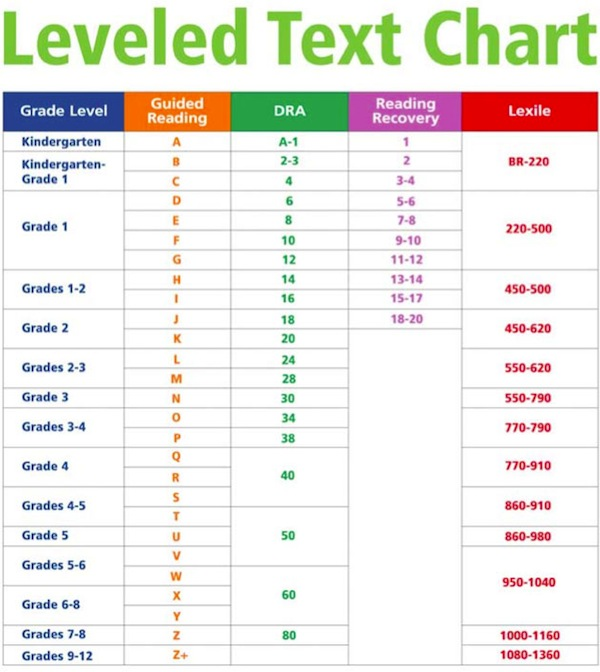

## Comparison To Other Algorithms
I gave other algorithms a seventh grade reading level to see how they perform since the reading level's neural network didn't seem to have much trouble classifying them and it resulted in not a so good estimate. Might be because of the dataset generation proccess or simply that my model is being tested on dataset it used to train.
Below you can find the document to see the results of an seventh grade from diffirent algorithms.

https://github.com/jamilton08/reading_level_language/blob/main/Readability%20Scoring%20System.pdf



# # Conclusion

Reading level are very measurable for a neural network, and a neural network does it effectively as well. The grades that were predicted wrong were still within their range for the most part according to the Lexile Text Standards. With a larger training dataset, this will surely be more effectly at distinguighing reading levels. 70% to 90% accuracy is the sweet spot for a model to perform in the real word and with a small sample, this did well. 